# Project: Investigating Medical Appointment No Shows
Author: Daniel Cummings  
Date: 5/3/2018  
Email: daniel.j.cummings@me.com  
Course: [Udacity](www.udacity.com) Data Analyst Nanodegree Program  
Source Data: [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments) via Udacity

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This project investigates possible factors behind whether or not patients miss their scheduled medical appointments. It was estimated in 2013 that missed appointments cost the U.S. health-care system more than **$150 billion** a year [(source)](http://www.post-gazette.com/business/businessnews/2013/02/24/No-shows-cost-health-care-system-billions/stories/201302240381). The source dataset for this study is comprised of 100k medical appointments in Brazil and includes various characteristics about the appointment such as the patient's preexisting conditions, gender, age, and welfare status. 

The following are some of the factors that will be investigated with regards to appointment attendance:
- How long between scheduling and the actual appointment date?
- Does the patient have a medical scholarship?
- What is the age of the patient?
- Are appointment text message reminders being sent to the patient?

The investigation is performed using Python with the pandas, numpy, and matplotlib tools. 

In [2]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# Seaborn style for matplotlib
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)

<a id='wrangling'></a>
## Data Wrangling

The medical appointment data was provided in *.csv* format and loaded using the pandas *read_csv* function. 

### General Properties

In [3]:
# Import dataset as pandas DataFrame
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


The DataFrame *info* function shows that the dataset has 14 categories and 110527 appointments. Fortunately, there are no data missing for any of the series. However, it is immediately apparent that there are some grammatical oddities in the column names. Additionally, the *ScheduledDay* and *AppointmentDay* series are not of the standard *datetime* type format.

In [4]:
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


Examining the contents of each series yields the following insights:
- *Gender* is "F" = Female, "M" = Male
- *Age* is in integers of years old
- *Neighbourhood* lists the hospital location as a string
- *Scholarship, Hipertension, Diabetes, Alcoholism, Handcap, SMS_received* follow the convention 1 = True, 0 = False as integer type series  

*No-show* does not follow the convention of the other series and will be explored next. 

In [5]:
print(type(df['No-show'][0]))
df['No-show'].value_counts()

<class 'str'>


No     88208
Yes    22319
Name: No-show, dtype: int64

The *"No-show"* series consists of "Yes" or "No" as string types. The definition of "Yes" in this context is that the patient did **not** show up for the appointment. This convention is somewhat confusing and will be adjusted later.

In [6]:
print("Number of duplicate rows: {}".format(sum(df.duplicated())))

Number of duplicate rows: 0


There are no duplicate rows in the dataset and none will be removed at this point. 

### Data Cleaning and Enhancement
The above DataFrame exploration highlighted the following areas where the dataset could be cleaned and enhanced:  
- Update the naming and syntax of the column names
- Change the column name, type and polarity of the *No-show* series
- Convert the *ScheduledDay* and *AppointmentDay* to the datetime format for better manipulation
- Add series for the time between scheduling->appointment and day of week

In [9]:
# Format column names
df.columns = [title.replace("-", "_").lower() for title in df.columns] 

The format of the column names are changed to underscore only and lower case as a matter of preference. 

In [10]:
# Drop appointmentid series from DataFrame
df.drop(['appointmentid'], axis=1, inplace=True) 

The *appointmentid* series did not seem useful for this particular investigation and is dropped from the DataFrame.

In [11]:
# Invert 'show' definition and fix hypertension grammar
df.rename(columns={'no_show': 'show', 'hipertension': 'hypertension',\
                  'neighbourhood': 'neighborhood','handcap': 'handicap'}, inplace=True)
df = df.replace({'show': {'Yes': False, 'No': True}})

The grammatical naming of the columns are updated to American english using the *df.rename* function. Next, the polarity of the *no_show* column is updated and converted to a Boolean type. Therefore, if a patient showed up to an appointment, the **show** result would be **True**.

In [12]:
# Convert to datatime type and add column with scheduled->appointment delta 
df['scheduledday'] = pd.to_datetime(df['scheduledday'])
df['appointmentday'] = pd.to_datetime(df['appointmentday'])
df['daysbetween'] = df['appointmentday'].dt.date - df['scheduledday'].dt.date
df['dayofweek'] = df['appointmentday'].dt.weekday

The datatime type is the standard *time* format for pandas. The 'scheduledday' and 'appointmentday' are easily converted to this type since the string syntax was already in a compatible format. 

Because data related the appointment day of the week and the time between scheduling will be investigated later, the *daysbetween* and *dayofweek* series were created and added to the DataFrame. For *daysbetween*, there was no hour/minute data available for the 'appointmentday' series so the time delta is in days. 

In [13]:
df.describe()

,patientid,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,daysbetween,dayofweek
count,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527,110527.000000
mean,1.474963e+14,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,10 days 04:24:31.828602,1.858243
std,2.560949e+14,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,15 days 06:07:11.673762,1.371672
min,3.921784e+04,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6 days +00:00:00,0.000000
25%,4.172614e+12,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00,1.000000
50%,3.173184e+13,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4 days 00:00:00,2.000000
75%,9.439172e+13,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15 days 00:00:00,3.000000
max,9.999816e+14,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179 days 00:00:00,5.000000


The series **age** and **daysbetween** show some odd data at the minimum. Therefore, a floor of "0" is set for both series with the following commands. (*Alternatively the data could be dropped from the DataFrame.*)

In [14]:
#Set a floor of 0 for both series
df.loc[df['age'] < 0, 'age'] = 0
df.loc[df['daysbetween'] < '0 days', 'daysbetween'] = 0
# Set daysbetween timedelta64 type to int for easier plotting
df['daysbetween'] = df['daysbetween'] / np.timedelta64(1, 'D')
df.describe()

,patientid,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,daysbetween,dayofweek
count,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,37.088883,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,10.183792,1.858243
std,2.560949e+14,23.110190,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,15.254924,1.371672
min,3.921784e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.173184e+13,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000
75%,9.439172e+13,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000,3.000000
max,9.999816e+14,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000,5.000000


<a id='eda'></a>
## Exploratory Data Analysis

Now that the dataset is cleaned up, some of the factors that relate to "No Show" appointments will be investigated below.

### How does the time between scheduling and the appointment affect attendance?

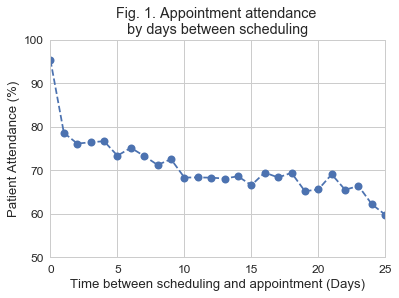

In [16]:
# Sort DataFrame by days between, convert to %
df_daysbetween = df.groupby('daysbetween').mean()*100

# Create line plot
df_daysbetween['show'].plot(kind='line', xlim=(0,25), ylim=(50,100),\
                           marker='o', linestyle='dashed', markersize=8)
plt.title('Fig. 1. Appointment attendance \nby days between scheduling')
plt.xlabel('Time between scheduling and appointment (Days)')
plt.ylabel('Patient Attendance (%)');

Figure 1 shows the patient attendance appointment rate versus the days between scheduling and the appointment day. Patients who schedule same day appointments were more likely to show up for the appointment than patients who schedule farther out in advance. In fact, the trend (up to 25 days) shows that the longer the time between scheduling and the appointment, the lower the attendance rate. 

### How does the age of the patient impact appointment attendance?

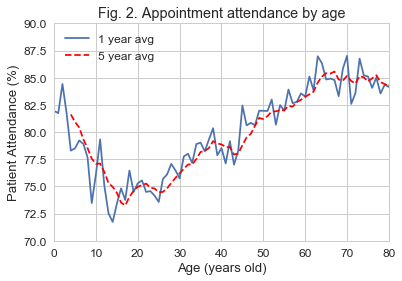

In [17]:
# Sort DataFrame by show or no show
df_show = df.query('show == True')
df_noshow = df.query('show == False')

# Find attendance rate by age group
age_all = df['age'].value_counts().sort_index()
age_show = df_show['age'].value_counts().sort_index()
age_pcnt = (age_show/age_all)*100
age_pcnt_mavg = age_pcnt.rolling(window=5).mean()

# Create line plot of attendance rate vs. age
age_pcnt.plot(kind='line', xlim=(0,80), ylim=(70,90), label='1 year avg')
age_pcnt_mavg.plot(kind='line', xlim=(0,80), ylim=(70,90),\
                   label='5 year avg', color='r', linestyle='--' )
plt.title('Fig. 2. Appointment attendance by age')
plt.xlabel('Age (years old)')
plt.ylabel('Patient Attendance (%)')
plt.legend();

Figure 2 shows the appointment attendance rate versus the patient's age. Young patients such a infants and toddlers and people older than 50 were much more likely to show up versus their teenage and young adult counterparts. It would be interesting to collect additional data on the teen's and 20's group to see what factors (e.g school, work, social) have the biggest impact on whether or not they show up for an appointment. 

### How does having a medical scholarship impact appointment attendance?
Note: The medical "scholarship" indicates enrollment in the Brasilian welfare program Bolsa Família.

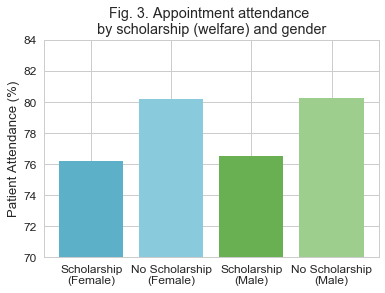

In [18]:
# Gender based appointment data for patients with a scholarship
schl_total_f = df.query('scholarship == 1 & gender == "F"').count()[0]
schl_showed_f = df.query('scholarship == 1 & show == True & gender == "F"').count()[0]
schl_pcnt_f = (schl_showed_f/schl_total_f)*100
schl_total_m = df.query('scholarship == 1 & gender == "M"').count()[0]
schl_showed_m = df.query('scholarship == 1 & show == True & gender == "M"').count()[0]
schl_pcnt_m = (schl_showed_m/schl_total_m)*100

# Gender based appointment data for patients without a scholarship
noschl_total_f = df.query('scholarship == 0 & gender == "F"').count()[0]
noschl_showed_f = df.query('scholarship == 0 & show == True & gender == "F"').count()[0]
noschl_pcnt_f = (noschl_showed_f/noschl_total_f)*100
noschl_total_m = df.query('scholarship == 0 & gender == "M"').count()[0]
noschl_showed_m = df.query('scholarship == 0 & show == True & gender == "M"').count()[0]
noschl_pcnt_m = (noschl_showed_m/noschl_total_m)*100

# Barplot comparing appointment attendance % with respect to scholarship and gender
x = np.arange(4)
y = [schl_pcnt_f, noschl_pcnt_f, schl_pcnt_m, noschl_pcnt_m]
colors = ['#5cb1c9', '#8acadd', '#68b052', '#9dce8e']
plt.bar(x, y, color=colors)
plt.xticks(x, ('Scholarship\n(Female)', 'No Scholarship\n(Female)',\
               'Scholarship\n(Male)', 'No Scholarship\n(Male)'))
plt.title('Fig. 3. Appointment attendance \nby scholarship (welfare) and gender')
plt.ylabel('Patient Attendance (%)')
plt.ylim(70,84)
plt.show()

Figure 3 breaks down the appointment attendance rate by gender and scholarship (welfare) status. The trend between gender is very similar for both cases related to scholarship. Patients on the scholarship program are less likely to show up for their appointments compared to those who don't have scholarships. The following are some factors that could give insight into this trend but cannot be answered with this dataset:
- Do patients with scholarships have less reliable modes of transportation?
- Is there a difference in financial penalties for missed appointments depending on scholarship?

### How does receiving text reminders impact appointment attendance?

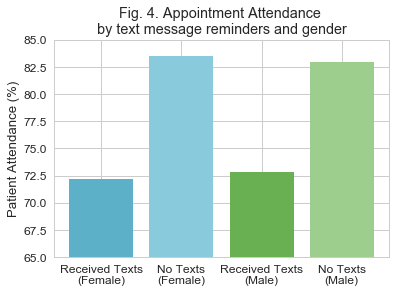

In [19]:
# Gender based appointment data for patients receiving text reminders
sms_f_total = df.query('sms_received == 1 & gender == "F"').count()[0]
sms_f_showed = df.query('sms_received == 1 & show == True & gender == "F"').count()[0]
sms_f_pcnt = (sms_f_showed/sms_f_total)*100
sms_m_total = df.query('sms_received == 1 & gender == "M"').count()[0]
sms_m_showed = df.query('sms_received == 1 & show == True & gender == "M"').count()[0]
sms_m_pcnt = (sms_m_showed/sms_m_total)*100

# Gender based appointment data for patients receiving text reminders
nosms_f_total = df.query('sms_received == 0 & gender == "F"').count()[0]
nosms_f_showed = df.query('sms_received == 0 & show == True & gender == "F"').count()[0]
nosms_f_pcnt = (nosms_f_showed/nosms_f_total)*100
nosms_m_total = df.query('sms_received == 0 & gender == "M"').count()[0]
nosms_m_showed = df.query('sms_received == 0 & show == True & gender == "M"').count()[0]
nosms_m_pcnt = (nosms_m_showed/nosms_m_total)*100

# Barplot comparing appointment attendance rate with respect to sms (text) and gender
x = np.arange(4)
y = [sms_f_pcnt, nosms_f_pcnt, sms_m_pcnt, nosms_m_pcnt]
colors = ['#5cb1c9', '#8acadd', '#68b052', '#9dce8e']
plt.bar(x, y, color=colors)
plt.xticks(x, ('Received Texts\n(Female)', 'No Texts\n(Female)',\
               'Received Texts\n(Male)', 'No Texts\n(Male)'))
plt.title("Fig. 4. Appointment Attendance \nby text message reminders and gender")
plt.ylabel('Patient Attendance (%)')
plt.ylim(65,85)
plt.show()

Figure 4 breaks down the appointment attendance rate by gender and whether or not a patient received text message reminders. The trend between genders is similar for both cases related to text reminders. The figure implies patients receiving text reminders are less likely to show up for their appointments compared to those who don't. However, more investigation is needed... this trend seems counterintuitive and will be proven as such by including the time between appointments trend below. 

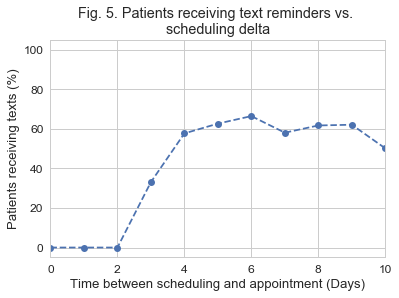

In [21]:
# Look at % of patients receiving texts vs days between
df_sms = df.groupby('daysbetween').mean()*100
df_sms['sms_received'].plot(kind='line', xlim=(0,10), marker='o',\
                            linestyle='dashed',)
plt.title('Fig. 5. Patients receiving text reminders vs. \nscheduling delta')
plt.xlabel('Time between scheduling and appointment (Days)')
plt.ylabel('Patients receiving texts (%)');

Figure 5 highlights the fact that patients do not received text reminders unless their appointment is scheduled three or more days out. Therefore, the this evaluation should be done for the range of three days and greater.

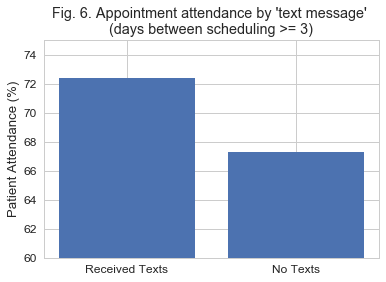

In [22]:
# Appointment data for patients receiving text reminders
sms_day_total = df.query('sms_received == 1 & daysbetween >= 3').count()[0]
sms_day_showed = df.query('sms_received == 1 & show == True & daysbetween >= 3').count()[0]
sms_day_pcnt = (sms_day_showed/sms_day_total)*100
nosms_day_total = df.query('sms_received == 0 & daysbetween >= 3').count()[0]
nosms_day_showed = df.query('sms_received == 0 & show == True & daysbetween >= 3').count()[0]
nosms_day_pcnt = (nosms_day_showed/nosms_day_total)*100

# Barplot comparing appointment attendance probablity with respect to sms (text) 
x = np.arange(2)
y = [sms_day_pcnt, nosms_day_pcnt]
plt.bar(x, y)
plt.xticks(x, ('Received Texts', 'No Texts'))
plt.title("Fig. 6. Appointment attendance by 'text message' \n(days between scheduling >= 3)")
plt.ylabel('Patient Attendance (%)')
plt.ylim(60,75)
plt.show()

Figure 6 shows a more honest picture of the impact of text reminders on attendance. Patients receive text reminders **if** their appointment is 3 or more days out. Therefore, patients who do get text reminders are more likely to show up to their appointment.

### How does the day of the week appointment impact attendance?

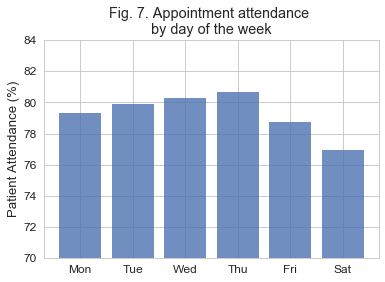

In [24]:
# Attendance rate vs appointment day of the week
daywk_all = df['dayofweek'].value_counts().sort_index()
daywk_show = df_show['dayofweek'].value_counts().sort_index()
daywk_pcnt = (daywk_show/daywk_all)*100

# Plot day of week appointment rate
plt.bar(daywk_pcnt.index, daywk_pcnt.values, alpha=0.8)
plt.title("Fig. 7. Appointment attendance \nby day of the week")
plt.ylabel('Patient Attendance (%)');
plt.xticks(daywk_pcnt.index, ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'))
plt.ylim(70, 84)
plt.show()

Figure 7 shows the appointment attendance rate based on day of the week. Patients with a Saturday appointment had a much lower attendance rate than those with appointments on Thursday. 

### How does the hospital location relate to appointment attendance?

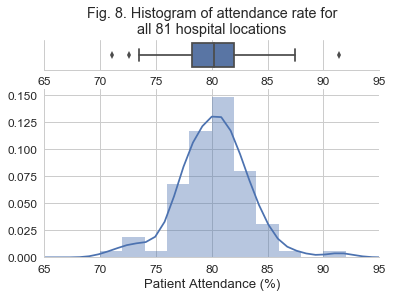

In [189]:
# Attendance rate by neighborhood hospital
locations = df['neighborhood'].value_counts().shape[0]
df_location = df.groupby(['neighborhood']).mean()*100

# Plot histogram with boxplot
# example: https://stackoverflow.com/questions/33381330/histogram-with-boxplot-above-in-python
x = df_location['show'].values

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x, ax=ax_box ).set_title("Fig. 8. Histogram of attendance rate for\
\nall {} hospital locations".format(locations))
sns.distplot(x, ax=ax_hist)
plt.xlim(65,95)
plt.xlabel('Patient Attendance (%)');
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

Figure 8 shows a histogram of attendance rate for each hospital location. In other words, for all appointments at a location, the rate of attendance was calculated. Then the results for all locations are plotted on a boxplot/histogram. The figure shows a close to normal distribution trend around the 80% attendance rate. Most locations have a range of patients showing up to appointments between a rate of 75-85%. Some locations only had a few points of data, therefore it is hard to draw definitive conclusions about each location unless all locations have an equally high sample population. 

### How do preexisting conditions relate to appointment attendance?

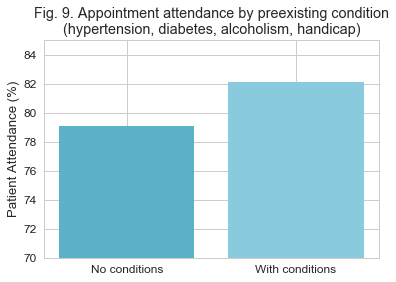

In [31]:
# Sort by preexisting conditions
cond_total = df.query('hypertension == 1 | diabetes == 1 \
| alcoholism == 1 | handicap == 1').count()[0]
cond_showed = df.query('show == True & (hypertension == 1 | diabetes == 1 \
| alcoholism == 1 | handicap == 1)').count()[0]
cond_pcnt = (cond_showed/cond_total)*100
nocond_total = df.query('hypertension == 0 & diabetes == 0 \
& alcoholism == 0 & handicap == 0').count()[0]
nocond_showed = df.query('show == True & (hypertension == 0 & diabetes == 0 \
& alcoholism == 0 & handicap == 0)').count()[0]
nocond_pcnt = (nocond_showed/nocond_total)*100

# Barplot comparing appointment attendance with respect to preexisting conditions
x = np.arange(2)
y = [nocond_pcnt, cond_pcnt]
colors = ['#5cb1c9', '#8acadd']
plt.bar(x, y, color=colors)
plt.xticks(x, ('No conditions', 'With conditions'))
plt.title('Fig. 9. Appointment attendance by preexisting condition\
\n(hypertension, diabetes, alcoholism, handicap)')
plt.ylabel('Patient Attendance (%)')
plt.ylim(70,85)
plt.show()

Figure 9 shows that patients with preexisting conditions show up for their appointments more than those without preexisting conditions.

<a id='conclusions'></a>
## Conclusions

The investigate of medical 'No Shows' resulted in some interesting insights:
- Patients have a lower attendance rate if appointments are scheduled farther out in advance (up to 25 days) days. Same day appointments have the highest attendance. 
- Patients less than 5 and greater than 50 years old have a higher attendance rate than the other age groups
- Those on the Brasilian welfare program have a lower attendance rate than those who are not on the program. 
- Text reminders are sent to some patients who have appointments scheduled 3 or more days out. Patients with appointments scheduled 3 or more days out had a higher attendance rate if they received reminders. 
- By day of the week, patients had the highest attendance on Thursday and the lowest on Saturday.
- The mean/median attendance rate for all hospital locations is about 80%.
- Patients with preexisting conditions have a higher appointment attendance rate than those without.

The investigation neglects (due to the dataset limitation) important socio-economic factors such as income and education which could reveal interesting correlations for patients using welfare, with preexisting conditions and the hospital locations. Some locations only had a few points of data, therefore the dataset could be made more robust with additional data for these cases.